In [1]:
%matplotlib inline
import random
from math import floor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, glob, math,time
from scipy import misc

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils
from PIL import Image


from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm 
from sklearn.preprocessing import MultiLabelBinarizer



# Choose dataset 

In [2]:
path2redux_data = "/home/e209440/data/redux/my_distract_driver_data_redux.npy" # 250 images
path2data = "/home/e209440/data/my_distract_driver_data.npy"

# Dataset Class with with split and transformations

In [3]:
class KaggleSafeDriverDataset(Dataset):
    """
    Arguments:
        Path to data (redux or not)
        PIL transforms
        Test data (boolean)
        Validation data (boolean)
        Size of validation data 
        Shuffle indices of validation and Train
        
    """

    def __init__(self, data_path, transform=None, is_test=False,is_val=False,val_size=0.2,shuffle =True):
    
        self.data = np.load(data_path).item()

        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        
        if is_test:
            self.X = self.data['X_test']
            self.y = tc.from_numpy(np.zeros(self.X.shape)).type(tc.FloatTensor) #Gambiarra para poder criar DataSet do Test.
        
        else:
            length = self.data['X_train'].shape[0]
            indices = list(range(1,length))
            split = floor(val_size * length)
            
            if shuffle :
                random.seed(378792)
                random.shuffle(indices)
            
            indtr = indices[split:]
            indval = indices[:split]
            
            
            if is_val:
                
                self.X= self.data['X_train'].take(indval,axis=0)
                self.y = self.mlb.fit_transform((self.data['Y_train'].take(indval,axis=0)).reshape(-1,1)).astype(np.float32)
            
            else:
                self.X= self.data['X_train'].take(indtr,axis=0)
                self.y = self.mlb.fit_transform((self.data['Y_train'].take(indtr,axis=0)).reshape(-1,1)).astype(np.float32)
    
   
    def __getitem__(self, index):
        img = Image.open(self.X[index])
        if self.transform is not None:
            img = self.transform(img)
        
        label = torch.from_numpy(self.y[index])
        return img, label

    def __len__(self):
        return len(self.X)
    

In [4]:
transformations = transforms.ToTensor()

trainset = KaggleSafeDriverDataset(path2redux_data,transformations)

In [5]:
testset= KaggleSafeDriverDataset(path2redux_data,transformations,is_test=True)

In [6]:
valset= KaggleSafeDriverDataset(path2redux_data,transformations,is_val=True)

In [7]:
trainset.X.shape,trainset.y.shape,testset.X.shape

((199, 3, 50, 50), (199, 10), (250, 3, 50, 50))

In [8]:
valset.X.shape, valset.y.shape

((50, 3, 50, 50), (50, 10))

In [9]:
train_loader = DataLoader(trainset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=4 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )

train_loader = DataLoader(valset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=4 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )


test_loader = DataLoader(testset,
                          batch_size=256,
                          shuffle=False,
                          num_workers=4 # 1 for CUDA
                         # pin_memory=True # CUDA only
                         )

# Plotting some examples

In [10]:
# Stub function 

# We need to adjust it to get images from either the test_loader(DataLoader) or trainset(Dataset)

# There is an example in https://t-adessowiki.fee.unicamp.br/user/e209440/notebooks/ia368z_2s2017/lotufo/ia368z/deliver-pytorch/Cats_and_dogs.ipynb

def plot_classes(labels, X, Y, img_size):
 """    #plt.figure(figsize=(20,10))
    size_subp= len(labels)
    cnt=1
    for i in labels:
        plt.figure()
        ix = random.randint(0, len(np.where(Y==str(i))[0]))
        ind = np.where(Y==int(i[-1]))[0][ix]
        image = X[ind].reshape(3,img_size,img_size).transpose((1,2,0))
        #plt.subplot(5,2, cnt)
        plt.imshow(image, cmap=plt.cm.gray_r)
        plt.axis('off')
        plt.title(labels[i])
        cnt +=1 
 """        

In [11]:
#plot_classes(labels, data['X_train'], data['Y_train'], img_size)

# Data Analysis

In [12]:
def de_para(dataset): 
    labels = {  'c0' : 'safe driving', 
                'c1' : 'texting - right', 
                'c2' : 'talking on the phone - right', 
                'c3' : 'texting - left', 
                'c4' : 'talking on the phone - left', 
                'c5' : 'operating the radio', 
                'c6' : 'drinking', 
                'c7' : 'reaching behind', 
                'c8' : 'hair and makeup', 
                'c9' : 'talking to passenger'}
    y = dataset.mlb.inverse_transform(dataset.y)
    class_number = [item[0] for item in y]
    class_str = []
    for item in class_number:
        class_str.append(labels['c'+str(item)])
            
    return class_str        
    

In [13]:
class_str = de_para(trainset)
class_str

['talking on the phone - left',
 'talking on the phone - left',
 'texting - left',
 'texting - left',
 'talking on the phone - right',
 'drinking',
 'drinking',
 'reaching behind',
 'drinking',
 'reaching behind',
 'talking on the phone - left',
 'safe driving',
 'texting - left',
 'operating the radio',
 'drinking',
 'texting - left',
 'texting - right',
 'texting - right',
 'talking to passenger',
 'operating the radio',
 'safe driving',
 'talking on the phone - left',
 'texting - right',
 'talking to passenger',
 'texting - right',
 'talking to passenger',
 'operating the radio',
 'talking on the phone - left',
 'operating the radio',
 'texting - left',
 'reaching behind',
 'safe driving',
 'operating the radio',
 'safe driving',
 'reaching behind',
 'talking to passenger',
 'texting - left',
 'talking on the phone - left',
 'reaching behind',
 'drinking',
 'hair and makeup',
 'texting - right',
 'drinking',
 'reaching behind',
 'talking to passenger',
 'reaching behind',
 'talking 

/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


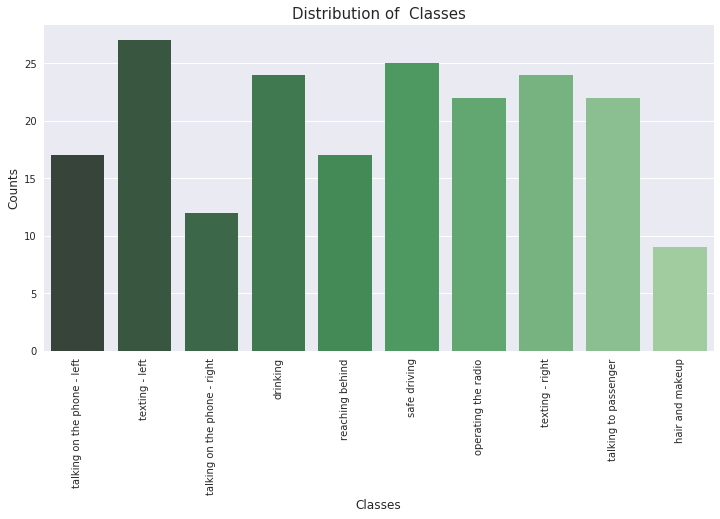

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(x=class_str, palette="Greens_d");
plt.xlabel("Classes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=90)
plt.title("Distribution of  Classes", fontsize=15)
plt.show()